# Text preprocessing

In [ ]:
import os
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

In [8]:
def tokenize(text):
    """
    Tokenize, lemmatize, remove stopwords and punctuations from an input text.
    
    Parameters
    ----------
    text: str, input text
    
    Returns
    -------
    str, preprocessed text
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    tokens = nltk.word_tokenize(text)
    text = [word for word in tokens if word not in string.punctuation]
    
    return " ".join([lemmatizer.lemmatize(word.lower()) for word in text if word.lower() not in stop_words])

In [16]:
def preprocess_summaries(readpath, savepath=None):
    """
    Preprocess all movie summaries.
    
    Parameters
    ----------
    readpath: str, path to original summaries (.txt)
    savepath: str, path to preprocessed summaries (.csv)
    
    Returns
    -------
    original_summaries: list, original summaries
    df: pandas.DataFrame, preprocessed summaries with movie_id as index
    """
    with open(readpath, encoding='utf-8') as f:
        content = f.readlines()
    original_summaries = [x.strip() for x in content] 
    summaries = [tokenize(d).split() for d in original_summaries]
    summaries = {summary[0]: " ".join(summary[1:]) for summary in summaries}
    
    df = pd.DataFrame.from_dict(summaries, orient='index', columns=['text'])
    df.index = df.index.astype('int64').rename('movie_id')
    
    if savepath is not None:
        df.to_csv(savepath)
    return original_summaries, df

In [17]:
readpath = "./data/plot_summaries.txt"
savepath = "./generated/summaries.csv"
os.makedirs("./generated/", exist_ok=True)

original_summaries, summaries = preprocess_summaries(readpath, savepath)

In [18]:
original_summaries[0] # original

"23890098\tShlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."

In [20]:
summaries.iloc[0]['text'] # preprocessed

"shlykov hard-working taxi driver lyosha saxophonist develop bizarre love-hate relationship despite prejudice realize n't different"

# Join movie metadata

In [2]:
import pandas as pd

In [3]:
colnames = ['movie_id', 'freebase_id', 'movie_name', 'date', 'revenue', 'runtime', 'language', 'country', 'genre']
movies = pd.read_csv('./data/movie.metadata.tsv',
                    sep='\t',
                    header=None,
                    names=colnames)
movies.head()

,movie_id,freebase_id,movie_name,date,revenue,runtime,language,country,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
summaries = pd.read_csv("./generated/summaries.csv")
df = summaries.merge(movies, on="movie_id", how="inner")
# convert "genre" column to dictionary and expand it into new rows
df.genre = df.genre.apply(lambda x: list(eval(x).values()))
df = df.explode('genre').reset_index(drop=True)
df.head()

,movie_id,text,freebase_id,movie_name,date,revenue,runtime,language,country,genre
0,23890098,shlykov hard-working taxi driver lyosha saxoph...,/m/076w2lb,Taxi Blues,1990-09-07,NaN,110.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/0f8l9c"": ""France"", ""/m/05vz3zq"": ""Soviet ...",Drama
1,23890098,shlykov hard-working taxi driver lyosha saxoph...,/m/076w2lb,Taxi Blues,1990-09-07,NaN,110.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/0f8l9c"": ""France"", ""/m/05vz3zq"": ""Soviet ...",World cinema
2,31186339,nation panem consists wealthy capitol twelve p...,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Action/Adventure
3,31186339,nation panem consists wealthy capitol twelve p...,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Science Fiction
4,31186339,nation panem consists wealthy capitol twelve p...,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Action


# NRC lexicon

In [10]:
lexicon = pd.read_csv("./lexicons/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", 
                      sep="\t", names=["word", "emotion", "label"], header=0)
lexicon = lexicon[lexicon.label==1].drop("label", axis=1)
lexicon.head()

,word,emotion
18,abacus,trust
22,abandon,fear
24,abandon,negative
26,abandon,sadness
29,abandoned,anger


# Emotion distribution analysis

**Idea:** Use normalized emotion distribution instead of sentiment score as the predictor in regression analysis.

In [19]:
from collections import defaultdict

counts = defaultdict(int)
emotions = lexicon["emotion"].unique()
text = df.iloc[2]["text"] # example

for emotion in emotions:
    words = lexicon.groupby("emotion")["word"].get_group(emotion).astype(str).values
    counts[emotion] += sum(word in words for word in text.split())

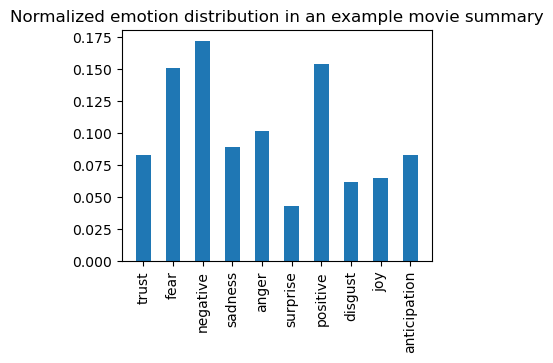

In [35]:
import matplotlib.pyplot as plt

counts = {k: v/sum(counts.values()) for k, v in counts.items()}

plt.figure(figsize=(4, 3))
plt.bar(counts.keys(), counts.values(), width=0.5)
plt.xticks(rotation=90)
plt.title("Normalized emotion distribution in an example movie summary")
plt.show()